In [1]:
import numpy as np 
from utils_2d import offline_opt 
from utils_2d import search_linear
from utils_2d import vis
import matplotlib.pyplot as plt

Implement R-OBD controller for 2-d system in canonical form.

The dynamics is
$$x_{t+1} = A x_t + B(u_t + w_t),$$
where
$$A = \begin{pmatrix}0 & 1\\ - 1 & 2\end{pmatrix}, B = \begin{pmatrix}0\\1\end{pmatrix}.$$

The cost is
$$\sum_{t=0}^TQ\|x_t\|^2+\|u_t\|^2$$

Define 
$$y_t = 2 y_{t-1} - y_{t-2} + u_t,$$
where $y_{-1} = y_{-2} = 0$.

Define
$$z_t = 2 z_{t-1} - z_{t-2} + w_t,$$
where $z_{-1} = x_0^{(2)}, z_{-2} = x_0^{(1)}$.

Notice that after defining $y_t$ and $z_t$, we can represent $x_{t+1}$ as
$$x_{t+1}^{(1)}=x_{t}^{(2)},x_{t+1}^{(2)}=y_t+z_t.$$

Then we can transform the online control problem to an online optimization with memory, where hitting cost is $f_t(y) = 2Q (y + z_t)^2$ and the switching cost is $c(y) = (y - 2y_{t-1} + y_{t-2})^2$.

After solving $y_t$, we use
$$u_t = y_t - 2 y_{t-1} + y_{t-2}$$
to determine the control action $u_t$.

In [2]:
class ROBD_Controller:
    def __init__(self, x0, Q, lambda_1, lambda_2, epsilon=0, Optimistic=False, Smooth=True):
        '''
        ROBD:       Optimistic=False
        Op-ROBD:    Optimistic=True
        If Smooth=True, the estimation set W_t = w_{t-1} + (-epsilon, epsilon)
        If Smooth=False, the estimation set W_t = (-epsilon, epsilon)
        '''
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.Optimistic = Optimistic
        self.Smooth = Smooth
        self.epsilon = epsilon
        self.Q = Q
        self.x = [x0]
        self.u = [0.0]
        self.y = [0.0, 0.0] #for convenience, we query y_t by index, self.y=[y_{t-1}, y_{t-2}]
        self.noisy_y = [0.0, 0.0] #This is a noisy estimation of accurate y
        self.z = [x0[0, 0], x0[1, 0]] #for convenience, we query z_t by index
        self.w_seq = [0.0] #noise sequence
        self.trace = []
    def ROBD(self, z, y):
        temp = 2*self.Q*z + self.lambda_1 * (-2*y[0] + y[1]) + self.lambda_2 * z
        return - temp / (2*self.Q + self.lambda_1 + self.lambda_2)
    
    #Tell the current state to the algorithm, ask it to determine the control action
    def query(self, state, w_next=0):
        if(len(self.x) >= 2): #we do not compute the noise when the game begins
            last_w = (state - A @ self.x[-1] - self.u[-1] * B) #compute the noise in the last step
            self.w_seq.append(last_w[1, 0]) #record the last noise
        self.x.append(state)
        
        if(len(self.x) >= 3):
            #First, calculate the accurate y_{t-1} using the knowledge of accurate w_{t-1}
            last_z = 2 * self.z[-1] - self.z[-2] + self.w_seq[-1]
            self.z.append(last_z)
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]]) #Oracle ROBD's action
            self.y.append(last_y)    
        
        #Next, use w_{t-1} as an estimation of w_t and calculate u_t
        if not self.Optimistic:
            last_z = 2 * self.z[-1] - self.z[-2] + w_next # ROBD
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]])
        else:
            # If smooth, | z - (2 * self.z[-1] - self.z[-2] + self.w_seq[-1]) | < epsilon
            # If not smooth, | z - (2 * self.z[-1] - self.z[-2]) | < epsilon
            if self.Smooth:
                last_z = 2 * self.z[-1] - self.z[-2] + self.w_seq[-1]
            else:
                last_z = 2 * self.z[-1] - self.z[-2]
            stationary_y = -2 * self.y[-1] + self.y[-2]
            if(stationary_y < last_z - self.epsilon):
                last_z -= self.epsilon
            elif(stationary_y > last_z + self.epsilon):
                last_z += self.epsilon
            else:
                last_z = stationary_y
            last_y = self.ROBD(last_z, [self.y[-1], self.y[-2]])
            
        last_u = last_y - 2 * self.noisy_y[-1] + self.noisy_y[-2]
        self.noisy_y.append(last_y)
        self.u.append(last_u)
        return last_u
    
    #Calculate the total cost of ROBD on a sequence of noise w_t
    def total_cost(self, noise_seq, x0):
        total = 0.0
        state = x0
        self.trace = []
        for t in range(T):
            control_action = self.query(state, w_next=noise_seq[0, t]) #query the control action
            state = A @ state + (control_action + noise_seq[0, t]) * B #evolve
            total += Q * (np.matmul(np.transpose(state), state))[0, 0]
            total += control_action**2
            self.trace.append(state[0, 0])
        return total

In [3]:
T = 200
x0 = np.array([0.0, 0.0])
Q = 8
A = np.array([[0.0, 1.0], [-1.0, 2.0]])
B = np.array([[0.0], [1.0]])

cost(OPT) = 56.25563492901519
cost(LC) = 1431.8963525483425
K* = [[ 0.96322785 -1.89208861]]
cost(LC)/cost(OPT) = 25.453385324957157


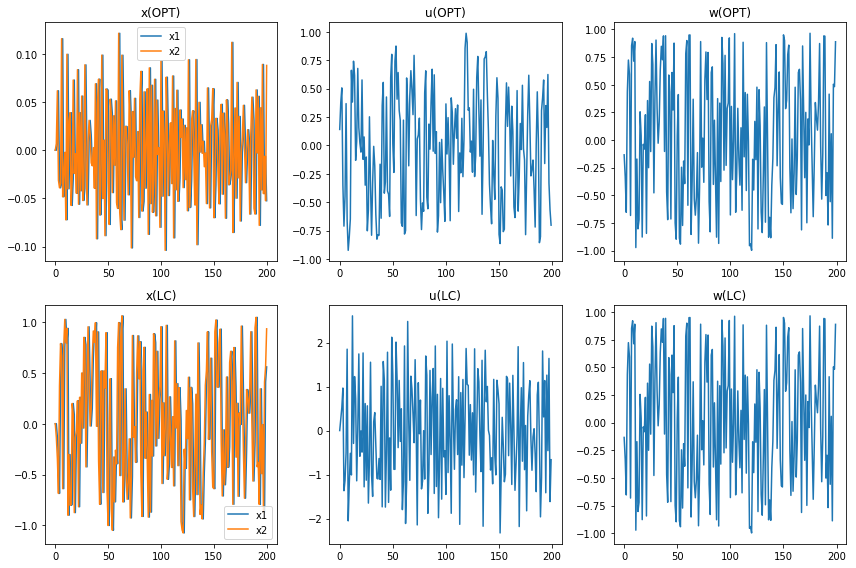

In [4]:
# Random w
w = 2 * (np.random.uniform(size=[1, T]) - 0.5)
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

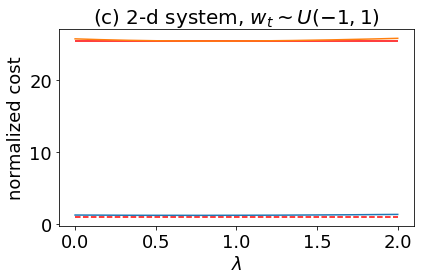

cost(OPT) = 56.25563492901519
cost(LC) = 1431.8963525483425
K* = [[ 0.96322785 -1.89208861]]
cost(LC)/cost(OPT) = 25.453385324957157
ROBD: The minimum cost is: 68.12802893795339  achieved at lambda =  0.6834170854271356
Op_ROBD: The minimum cost is: 1432.28636528723  achieved at lambda =  0.8542713567839196


In [5]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=1.0, Optimistic=True, Smooth=False)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
#plt.locator_params(nbins=5, axis='y')
plt.title(r'(c) 2-d system, $w_t\sim U(-1,1)$', fontsize=20)
plt.tight_layout()
#plt.savefig('random_2d.pdf')
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])

cost(OPT) = 304.2481034299074
cost(LC) = 885.2156350462701
K* = [[ 0.21132911 -3.56335443]]
cost(LC)/cost(OPT) = 2.909518991464168


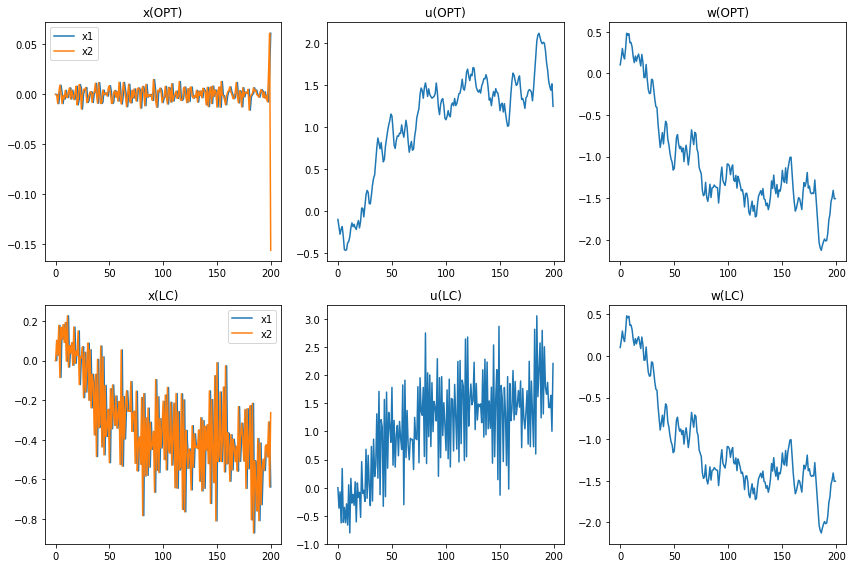

In [10]:
# Random walk w
temp = 0.4 * (np.random.uniform(size=T+1) - 0.5)
for t in range(T):
    w[0, t] = np.sum(temp[:t+1])
        
x_opt, u_opt, loss_opt = offline_opt(x0, Q, A, B, T, w)
x_lc, u_lc, loss_lc, K_opt = search_linear(Q, A, B, x0, w, T)
print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)

vis([[x_opt, u_opt, w], [x_lc, u_lc, w]], ['OPT', 'LC'])

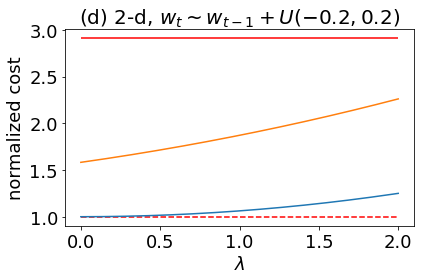

cost(OPT) = 304.2481034299074
cost(LC) = 885.2156350462701
K* = [[ 0.21132911 -3.56335443]]
cost(LC)/cost(OPT) = 2.909518991464168
ROBD: The minimum cost is: 304.75697471118536  achieved at lambda =  0.0
Op_ROBD: The minimum cost is: 481.6853352102367  achieved at lambda =  0.0


In [11]:
lam = np.linspace(0, 2, 200)
ROBD = []
Op_ROBD = []
for l in lam:
    ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0)
    ROBD_cost = ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    Op_ROBD_instance = ROBD_Controller(x0=x0.reshape([2, 1]), Q=Q, lambda_1=l, lambda_2=0.0, epsilon=0.2, Optimistic=True, Smooth=True)
    Op_ROBD_cost = Op_ROBD_instance.total_cost(w, x0=x0.reshape([2, 1]))
    
    ROBD.append(ROBD_cost)
    Op_ROBD.append(Op_ROBD_cost)

plt.plot(lam, ROBD/loss_opt)
plt.plot(lam, Op_ROBD/loss_opt)
plt.hlines(y=loss_lc/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r')
plt.hlines(y=loss_opt/loss_opt, xmin=lam[0], xmax=lam[-1], colors='r', linestyles='--')
plt.xlabel(r'$\lambda$', fontsize=18)
plt.ylabel('normalized cost', fontsize=18)
plt.tick_params(labelsize=18)
#plt.locator_params(nbins=5, axis='y')
plt.title(r'(d) 2-d, $w_t\sim w_{t-1}+U(-0.2,0.2)$', fontsize=20)
plt.tight_layout()
#plt.savefig('random_walk_2d.pdf')
plt.show()

print('cost(OPT) =', loss_opt)
print('cost(LC) =', loss_lc)
print('K* =', K_opt)
print('cost(LC)/cost(OPT) =', loss_lc/loss_opt)
print("ROBD: The minimum cost is:", np.min(ROBD), " achieved at lambda = ", lam[np.argmin(ROBD)])
print("Op_ROBD: The minimum cost is:", np.min(Op_ROBD), " achieved at lambda = ", lam[np.argmin(Op_ROBD)])